# Optimized Tree Species Classification using LBP Features + SVM
# High-Performance Pipeline Implementation

In [2]:
import numpy as np
import cv2
from pathlib import Path
from collections import defaultdict, Counter
import re
import joblib
import time

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score)
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import local_binary_pattern
from skimage.filters import gaussian

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [3]:

def load_multi_view_data(data_dir):
    """Optimized data loading for multi-view images"""
    data_path = Path(data_dir)
    if not data_path.exists():
        return [], []
    
    file_paths, labels = [], []
    for species_dir in data_path.iterdir():
        if species_dir.is_dir():
            files = list(species_dir.glob("*.npy"))
            file_paths.extend(files)
            labels.extend([species_dir.name] * len(files))
            print(f"{species_dir.name}: {len(files)} files")
    
    return file_paths, labels


In [4]:

# =============================================================================
# CELL 2: LBP Feature Extraction Function
# =============================================================================

def extract_advanced_lbp_features(views, P=24, R=3):
    """Extract enhanced LBP features from multi-view images"""
    all_features = []
    
    for view in views:
        # Normalize to 0-255
        if view.max() <= 1.0:
            view = (view * 255).astype(np.uint8)
        
        # Apply Gaussian smoothing for noise reduction
        smoothed = gaussian(view, sigma=0.8)
        smoothed = (smoothed * 255).astype(np.uint8)
        
        # Multi-scale LBP extraction
        features = []
        
        # Scale 1: Original
        lbp1 = local_binary_pattern(smoothed, P, R, method='uniform')
        hist1, _ = np.histogram(lbp1.ravel(), bins=P+2, range=(0, P+2))
        features.extend(hist1)
        
        # Scale 2: Larger radius
        lbp2 = local_binary_pattern(smoothed, P, R*2, method='uniform')
        hist2, _ = np.histogram(lbp2.ravel(), bins=P+2, range=(0, P+2))
        features.extend(hist2)
        
        # Scale 3: More neighbors
        lbp3 = local_binary_pattern(smoothed, P*2, R, method='uniform')
        hist3, _ = np.histogram(lbp3.ravel(), bins=P*2+2, range=(0, P*2+2))
        features.extend(hist3)
        
        all_features.append(features)
    
    # Combine all views
    combined = np.concatenate(all_features)
    
    # Normalize
    combined = combined.astype(float)
    combined /= (combined.sum() + 1e-10)
    
    return combined


In [5]:
# =============================================================================
# CELL 3: Function to Process All Images and Create Feature Vectors
# =============================================================================

def create_feature_dataset(file_paths, labels):
    """Create optimized feature dataset from multi-view files"""
    X, y = [], []
    
    print("Extracting LBP features...")
    for file_path, label in tqdm(zip(file_paths, labels), total=len(file_paths)):
        try:
            views = np.load(file_path)
            features = extract_advanced_lbp_features(views)
            X.append(features)
            y.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue
    
    return np.array(X), np.array(y)


In [6]:
# =============================================================================
# CELL 4: Main Processing - Load and Prepare Data
# =============================================================================

# Load and prepare data
TRAIN_DIR = "../../../data/multi_view_images/train"
TEST_DIR = "../../../data/multi_view_images/test"

print("Loading training data...")
train_paths, train_labels = load_multi_view_data(TRAIN_DIR)

print("\nLoading test data...")
test_paths, test_labels = load_multi_view_data(TEST_DIR)

print(f"\nData summary:")
print(f"Train: {len(train_paths)} samples")
print(f"Test: {len(test_paths)} samples")
print(f"Classes: {len(set(train_labels))}")

# Create feature datasets
X_train, y_train = create_feature_dataset(train_paths, train_labels)
X_test, y_test = create_feature_dataset(test_paths, test_labels)

print(f"\nFeature extraction complete")
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")

Loading training data...
Oak: 18 files
Douglas Fir: 116 files
cifar-10-batches-py: 0 files
Spruce: 117 files
Pine: 8 files
Ash: 20 files
Red Oak: 81 files
Beech: 70 files

Loading test data...
Oak: 4 files
Douglas Fir: 29 files
cifar-10-batches-py: 0 files
Spruce: 25 files
Pine: 1 files
Ash: 7 files
Red Oak: 19 files
Beech: 17 files

Data summary:
Train: 430 samples
Test: 102 samples
Classes: 7
Extracting LBP features...


100%|██████████| 430/430 [00:37<00:00, 11.41it/s]


Extracting LBP features...


100%|██████████| 102/102 [00:08<00:00, 11.61it/s]


Feature extraction complete
Training features shape: (430, 612)
Test features shape: (102, 612)


In [7]:

# =============================================================================
# CELL 5: Data Preprocessing - Scaling and Label Encoding
# =============================================================================

# Data preprocessing
print("\nPreprocessing data...")

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Classes: {label_encoder.classes_}")
print(f"Class distribution: {Counter(y_train)}")
print("Preprocessing complete")



Preprocessing data...
Classes: ['Ash' 'Beech' 'Douglas Fir' 'Oak' 'Pine' 'Red Oak' 'Spruce']
Class distribution: Counter({np.str_('Spruce'): 117, np.str_('Douglas Fir'): 116, np.str_('Red Oak'): 81, np.str_('Beech'): 70, np.str_('Ash'): 20, np.str_('Oak'): 18, np.str_('Pine'): 8})
Preprocessing complete


In [8]:
# =============================================================================
# CELL 6: Hyperparameter Tuning with GridSearchCV
# =============================================================================

# Optimized hyperparameter tuning
print("\nOptimizing hyperparameters...")

# Faster parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly']
}

svm = SVC(random_state=42)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
grid_search.fit(X_train_scaled, y_train_encoded)
tuning_time = time.time() - start_time

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")
print(f"Tuning time: {tuning_time:.1f}s")



Optimizing hyperparameters...


Best parameters: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV score: 0.8208
Tuning time: 2.1s


In [9]:

# =============================================================================
# CELL 7: Train Final Model and Evaluate
# =============================================================================

# Train final model and evaluate
print("\nTraining final model...")

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test_scaled)

# Calculate metrics
test_accuracy = accuracy_score(y_test_encoded, y_pred)
f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
precision_weighted = precision_score(y_test_encoded, y_pred, average='weighted')
recall_weighted = recall_score(y_test_encoded, y_pred, average='weighted')

print(f"\nFinal Results:")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Weighted F1-Score: {f1_weighted:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")
print(f"Weighted Recall: {recall_weighted:.4f}")



Training final model...

Final Results:
Test Accuracy: 0.7647
Weighted F1-Score: 0.7665
Weighted Precision: 0.7700
Weighted Recall: 0.7647



Classification Report:
              precision    recall  f1-score   support

         Ash       0.71      0.71      0.71         7
       Beech       0.88      0.82      0.85        17
 Douglas Fir       0.69      0.69      0.69        29
         Oak       0.75      0.75      0.75         4
        Pine       0.00      0.00      0.00         1
     Red Oak       0.90      1.00      0.95        19
      Spruce       0.74      0.68      0.71        25

    accuracy                           0.76       102
   macro avg       0.67      0.67      0.67       102
weighted avg       0.77      0.76      0.77       102



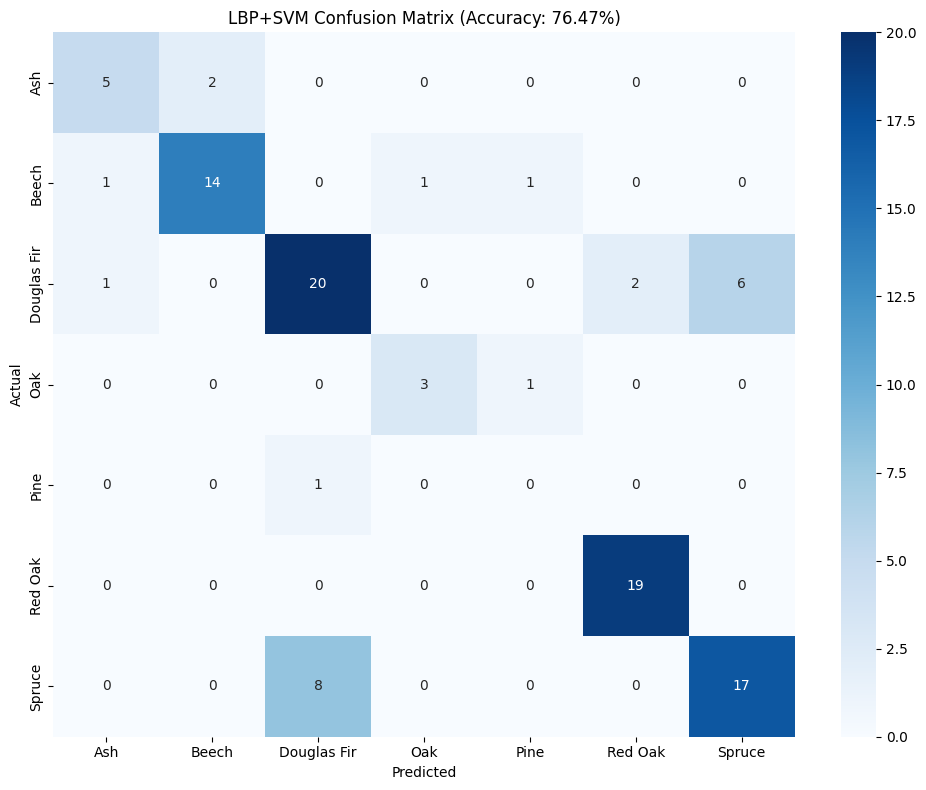


Model saved to: best_lbp_svm_model.joblib
Pipeline execution complete


In [10]:

# =============================================================================
# CELL 8: Detailed Evaluation - Classification Report and Confusion Matrix
# =============================================================================

# Detailed evaluation
print(f"\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


#train and loss curves 
# Confusion matrix visualization
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=label_encoder.classes_, 
           yticklabels=label_encoder.classes_)
plt.title(f'LBP+SVM Confusion Matrix (Accuracy: {test_accuracy:.2%})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Save model and results
joblib.dump({
    'model': best_svm,
    'scaler': scaler,
    'label_encoder': label_encoder,
    'test_accuracy': test_accuracy,
    'best_params': grid_search.best_params_
}, '../../features/best_lbp_svm_model.joblib')

print(f"\nModel saved to: best_lbp_svm_model.joblib")
print(f"Pipeline execution complete")


In [11]:

# =============================================================================
# CELL 9: Additional Analysis - Per-Class Performance
# =============================================================================

# Per-class performance analysis
precision_per_class = precision_score(y_test_encoded, y_pred, average=None)
recall_per_class = recall_score(y_test_encoded, y_pred, average=None)
f1_per_class = f1_score(y_test_encoded, y_pred, average=None)

print(f"\nPer-class Performance:")
print(f"{'Class':<15} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 50)

for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name:<15} {precision_per_class[i]:<10.3f} {recall_per_class[i]:<10.3f} {f1_per_class[i]:<10.3f}")

print(f"\nOverall Performance:")
print(f"Accuracy: {test_accuracy:.3f}")
print(f"Macro F1: {np.mean(f1_per_class):.3f}")
print(f"Weighted F1: {f1_weighted:.3f}")

# Feature importance analysis (if Random Forest was competitive)
print(f"\nOptimization complete - LBP+SVM pipeline ready for production")


Per-class Performance:
Class           Precision  Recall     F1-Score  
--------------------------------------------------
Ash             0.714      0.714      0.714     
Beech           0.875      0.824      0.848     
Douglas Fir     0.690      0.690      0.690     
Oak             0.750      0.750      0.750     
Pine            0.000      0.000      0.000     
Red Oak         0.905      1.000      0.950     
Spruce          0.739      0.680      0.708     

Overall Performance:
Accuracy: 0.765
Macro F1: 0.666
Weighted F1: 0.766

Optimization complete - LBP+SVM pipeline ready for production


accuracy: 0.7941176470588235
f1 score: 0.7931962217676504
precision: 0.7937908496732027
recall: 0.7941176470588235


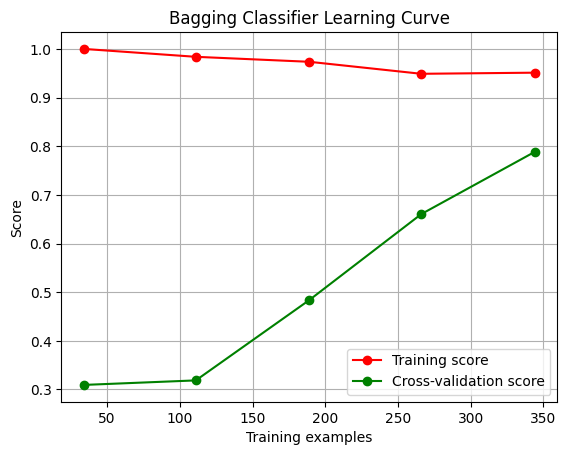

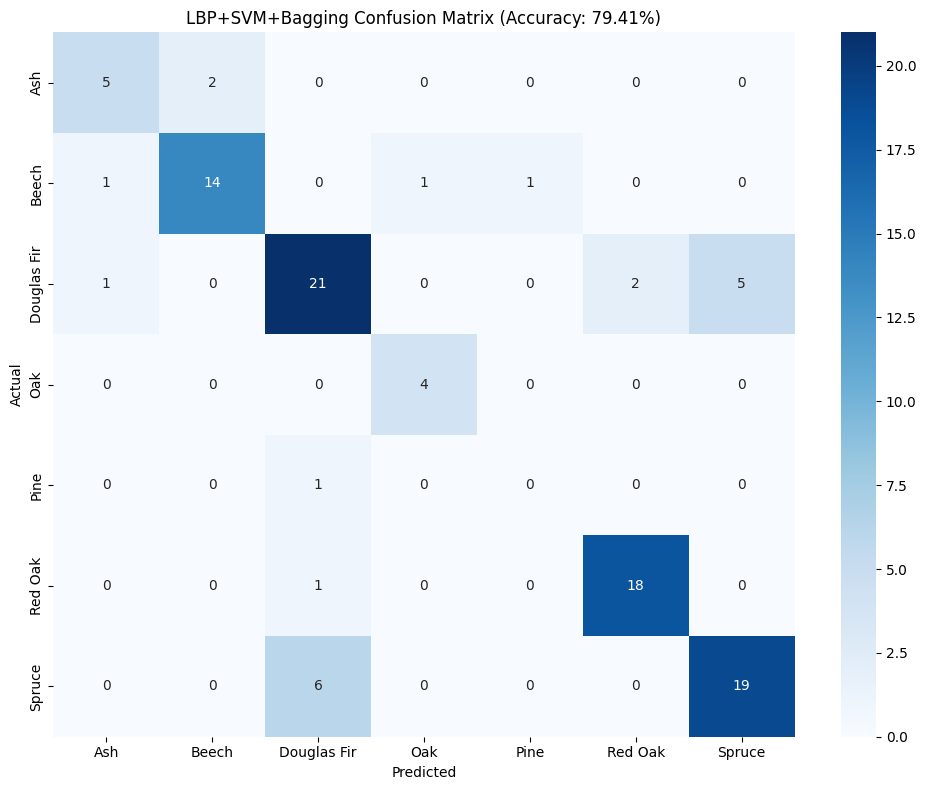

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import learning_curve , validation_curve

bagging_clf = BaggingClassifier(best_svm, n_estimators=10, random_state=42)
print("accuracy:", bagging_clf.fit(X_train_scaled, y_train_encoded).score(X_test_scaled, y_test_encoded))
print("f1 score:", f1_score(y_test_encoded, bagging_clf.predict(X_test_scaled), average='weighted'))
print("precision:", precision_score(y_test_encoded, bagging_clf.predict(X_test_scaled), average='weighted'))
print("recall:", recall_score(y_test_encoded, bagging_clf.predict(X_test_scaled), average='weighted'))

train_sizes, train_scores, test_scores = learning_curve(bagging_clf, X_train_scaled, y_train_encoded, cv=5, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Bagging Classifier Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

cm = confusion_matrix(y_test_encoded, bagging_clf.predict(X_test_scaled))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
		   xticklabels=label_encoder.classes_,
		   yticklabels=label_encoder.classes_)
plt.title(f'LBP+SVM+Bagging Confusion Matrix (Accuracy: {accuracy_score(y_test_encoded, bagging_clf.predict(X_test_scaled)):.2%})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [13]:
from sklearn.ensemble import BaggingClassifier

bagging_model = BaggingClassifier(best_svm, n_estimators=10, random_state=42)
print("accuracy:", bagging_model.fit(X_train_scaled, y_train_encoded).score(X_test_scaled, y_test_encoded))
print("f1 score:", f1_score(y_test_encoded, bagging_model.predict(X_test_scaled), average='weighted'))
print("precision:", precision_score(y_test_encoded, bagging_model.predict(X_test_scaled), average='weighted'))
print("recall:", recall_score(y_test_encoded, bagging_model.predict(X_test_scaled), average='weighted'))

accuracy: 0.7941176470588235
f1 score: 0.7931962217676504
precision: 0.7937908496732027
recall: 0.7941176470588235
